# Stationary Equilibrium

In this notebook, I illustrate the solution to the **stationary equilibrium** for the housing model.

## Setup and Solve

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy import optimize
from consav import linear_interp
from scipy import stats

# load the DurableConsumptionModel module
from HousingModel import HousingModelClass

# Set the number of threads in numba
nb.set_num_threads(4)

In [2]:
# Something for figure layout here
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('axes', axisbelow=True)

In [19]:
# Define the model
model = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})

# Solve and simulate
model.precompile_numba()
model.solve()
model.simulate()

In [5]:
model.solve_path()
model.simulate_path()

Determine aggregate supply so that the equilibrium price is 1

In [9]:
Hs = np.mean(model.sim.n)
print(Hs)

0.31576333475798035


# Find stationary equilibrium

Find demand curve over a grid of house prices

In [297]:
# Grid over house prices
Nr = 15
p_vec = np.linspace(.2,3.0,Nr)
p_min = p_vec[0]
p_max = p_vec[Nr-1]

# Supply
# Hs = 4.1 # Find some value

# Initialize demand function
Hd = np.zeros(shape=len(p_vec))

# Loop
t0 = time.time()
for i_p,p in enumerate(p_vec):
    
    # Solve and simulate model
    model.par.ph = p
    model.solve()
    model.simulate()
    
    # Aggregate demand
    Hd[i_p] = np.mean(model.sim.d[175:,:])
    
    # Bound on p
    diff = Hs - Hd[i_p]
    if diff < 0: p_min = np.fmax(p_min, p_vec[i_p])
    if diff > 0: p_max = np.fmin(p_max, p_vec[i_p])
    
    # print(i_p)
    
t1 = time.time()

In [298]:
print(t1-t0)

209.78582072257996


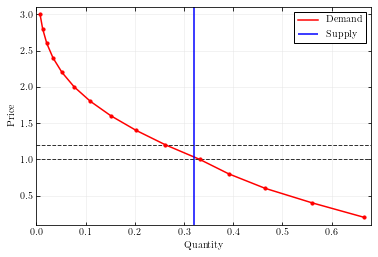

In [314]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(Hd,p_vec, color = 'red', label = 'Demand',zorder=2)
ax.scatter(Hd,p_vec, color = 'red',zorder=3, marker='o', s=10)

ax.vlines(0.32,0,10, color = 'blue', linestyle = '-', label ='Supply')
# ax.plot(Hd,supply, color = 'blue', linestyle = ':')

ax.hlines(p_min,0,2, linestyle='--', color = '0.2', linewidth = 1)
ax.hlines(p_max,0.0,2, linestyle='--', color = '0.2', linewidth = 1)

ax.set_xlim(0,.68)
ax.set_ylim(.1,3.1)
ax.set_xlabel('Quantity')
ax.set_ylabel('Price')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/equilibrium.pdf')

Last step

In [ ]:
def obj(p,model):
    
    model.par.ph = p
    model.solve()
    model.simulate()
    return np.mean(model.sim.n[-1,:]) - Hs

t0 = time.time()

opt = optimize.root_scalar(obj,bracket=[p_min,p_max],method='bisect',args=(model,),maxiter=100)
model.par.ph = opt.root
assert opt.converged

t1 = time.time()
print(t1-t0)

In [ ]:
print(opt)

## Plot Results

Plot the **policy functions** and **stationary distributions** from the model.
Also illustrate convergence of the distributions

### Plot the policy functions

Non-durable Consumption

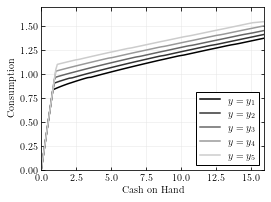

In [318]:
# Initialize the figure
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.plot(model.par.grid_m, model.sol.c_keep[0,0,0,9,:], color = '0', linewidth = '1.5', label = r'$y=y_1$')
ax.plot(model.par.grid_m, model.sol.c_keep[0,0,1,9,:], color = '0.2', linewidth = '1.5', label = r'$y=y_2$')
ax.plot(model.par.grid_m, model.sol.c_keep[0,0,2,9,:], color = '0.4', linewidth = '1.5', label = r'$y=y_3$')
ax.plot(model.par.grid_m, model.sol.c_keep[0,0,3,9,:], color = '0.6', linewidth = '1.5', label = r'$y=y_4$')
ax.plot(model.par.grid_m, model.sol.c_keep[0,0,4,9,:], color = '0.8', linewidth = '1.5', label = r'$y=y_5$')

# Plot setting
ax.set_xlabel('Cash on Hand')
ax.set_ylabel('Consumption')

ax.set_xlim(model.par.grid_m[0],model.par.grid_m[-1])
ax.set_ylim(0,1.7)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/c_keep.pdf')

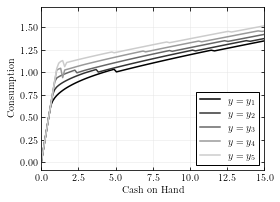

In [319]:
# Initialize the figure
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.plot(model.par.grid_x, model.sol.c_adj[0,0,0,:], linestyle = '-', color = '0', linewidth = '1.5', label = r'$y=y_1$')
ax.plot(model.par.grid_x, model.sol.c_adj[0,0,1,:], linestyle = '-', color = '0.2', linewidth = '1.5', label = r'$y=y_2$')
ax.plot(model.par.grid_x, model.sol.c_adj[0,0,2,:], linestyle = '-', color = '0.4', linewidth = '1.5', label = r'$y=y_3$')
ax.plot(model.par.grid_x, model.sol.c_adj[0,0,3,:], linestyle = '-', color = '0.6', linewidth = '1.5', label = r'$y=y_4$')
ax.plot(model.par.grid_x, model.sol.c_adj[0,0,4,:], linestyle = '-', color = '0.8', linewidth = '1.5', label = r'$y=y_5$')

# Plot setting
ax.set_xlabel('Cash on Hand')
ax.set_ylabel('Consumption')

ax.set_xlim(0,15)
# ax.set_ylim(0,1.35)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/c_adj.pdf')

Housing demand

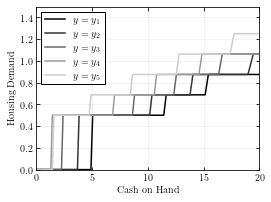

In [324]:
# Initialize the figure
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.plot(model.par.grid_x, model.sol.d_adj[0,0,0,:], linestyle = '-', color = '0', linewidth = '1.5', label = r'$y=y_1$')
ax.plot(model.par.grid_x, model.sol.d_adj[0,0,1,:], linestyle = '-', color = '0.2', linewidth = '1.5', label = r'$y=y_2$')
ax.plot(model.par.grid_x, model.sol.d_adj[0,0,2,:], linestyle = '-', color = '0.4', linewidth = '1.5', label = r'$y=y_3$')
ax.plot(model.par.grid_x, model.sol.d_adj[0,0,3,:], linestyle = '-', color = '0.6', linewidth = '1.5', label = r'$y=y_4$')
ax.plot(model.par.grid_x, model.sol.d_adj[0,0,4,:], linestyle = '-', color = '0.8', linewidth = '1.5', label = r'$y=y_5$')

# Plot setting
ax.set_xlabel('Cash on Hand')
ax.set_ylabel('Housing Demand')

ax.set_xlim(0,20)
ax.set_ylim(0,1.5)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/h_adj.pdf')

#### Convergence of dist

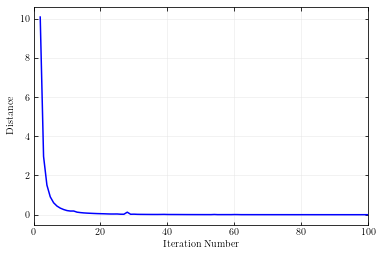

In [329]:
# plt.plot(range(200,0,-1),model1.sol.dist)

# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot and scatter
ax.plot(range(100,0,-1),model.sol.dist[100:], color = 'blue', linewidth = '1.5')

# Plot setting
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Distance')

ax.set_xlim(0,100)
# ax.set_ylim(0.25,2.0)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/dist.pdf')

## Plot Distributions

#### Wealth distribution

First, plot the distribution in a normal plot

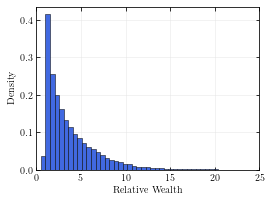

In [374]:
# Define wealth
w = (model.sim.m + model.par.ph*model.sim.n) / model.sim.y
# w2 = model.sim.m 

# w = model.sim.a + model.sim.d

# Initialize the figure
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
# ax.hist(w[-1,:], bins = 100, density = True, edgecolor = 'k', linewidth=.5, zorder=2, color ='royalblue', alpha = 1)
ax.hist(w[-1,:], bins = np.linspace(0,25,50), density = True, edgecolor = 'k', linewidth=.5, zorder=2, color ='royalblue', alpha = 1)

# ax.hist(w2[-1,:], bins = 50, density = True, edgecolor = 'k', linewidth=.5, zorder=2, color ='royalblue', alpha = .5)

# Plot setting
ax.set_xlabel('Relative Wealth')
ax.set_ylabel('Density')
ax.set_xlim(0,25)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/w_distr.pdf')

Use a log-log plot

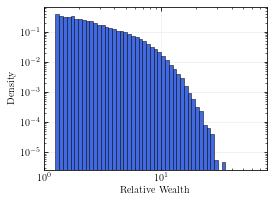

In [377]:
## Define wealth
w = (model.sim.m + model.par.ph*model.sim.n) / model.sim.y

# Initialize the figure
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.hist(w[-1,:], np.logspace(.1,2,60), density = True, edgecolor = 'k', linewidth=.5, zorder=2, color ='royalblue')

# Plot setting
ax.set_xlabel('Relative Wealth')
ax.set_ylabel('Density')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,80)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/w_distr_log.pdf')

#### Aggregate housing demand

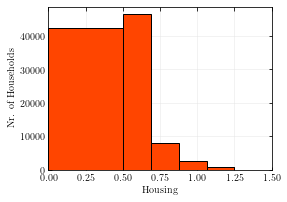

In [9]:
# Initialize the figure
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.hist(model.sim.d[-1,:], model.par.grid_n, density = False, facecolor='orangered', edgecolor = 'k', zorder=2)

# Plot setting
ax.set_xlabel('Housing')
ax.set_ylabel('Nr. of Households')

ax.set_xlim(0,1.5)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/h_distr.pdf')

### Plot Convergence of Simulation 

Simulate and check for convergence

In [246]:
# Vector of aggregates
h_agg = np.mean(model.sim.d, axis=1)
n_agg = np.mean(model.sim.n, axis=1)
c_agg = np.mean(model.sim.c, axis=1)
a_agg = np.mean(model.sim.a, axis=1)
m_agg = np.mean(model.sim.m, axis=1)
y_agg = np.mean(model.sim.y, axis=1)

Divide time series with the last period value to illustrate convergence

In [247]:
h_conv = h_agg / h_agg[-1]
c_conv = c_agg / c_agg[-1]
a_conv = a_agg / a_agg[-1]

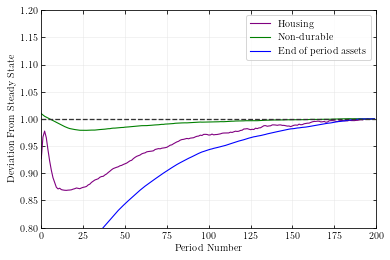

In [248]:
# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.plot(range(model.par.sim_T),h_conv, linestyle = '-', color = 'purple', linewidth = '1.1', label= 'Housing')
ax.plot(range(model.par.sim_T),c_conv, linestyle = '-', color = 'green', linewidth = '1.1', label='Non-durable')
ax.plot(range(model.par.sim_T),a_conv, linestyle = '-', color = 'blue', linewidth = '1.1', label='End of period assets')

ax.hlines(1,0,200, linestyle ='--', color = '0.2', linewidth = 1.3)

# Plot setting
ax.set_xlabel('Period Number')
ax.set_ylabel('Deviation From Steady State')

ax.set_xlim(0,200)
ax.set_ylim(0.8,1.2)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend()

plt.savefig('../../tex/figs/convergence.pdf')

## Descriptive Statistics from SS

Compute variables used

In [14]:
# Housing share of total consumption
h_share = model.sim.n[-1,:] / ((model.sim.m[-1,:] + model.sim.n[-1,:]) / model.sim.y[-1,:])

In [15]:
# try binned scatterplot
h_demand_means, bin_edges, binnumber = stats.binned_statistic(model.sim.m[-1,:],model.sim.d[-1,:], bins = np.logspace(0,2,30), statistic = 'mean')
h_share_means = stats.binned_statistic(model.sim.m[-1,:],h_share, bins = np.logspace(0,2,30), statistic = 'mean').statistic

# Compute bins
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

Binscatter of housing demand as a function of beginning of period cash on hand

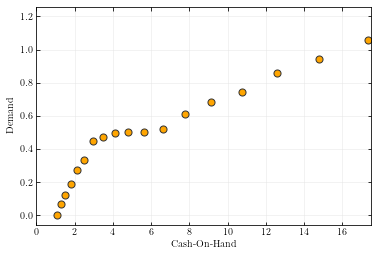

In [16]:
# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.scatter(bin_centers, h_demand_means, s=50, c='orange', marker='o', edgecolors = '0.2', zorder=2) 

# Plot setting
ax.set_xlabel('Cash-On-Hand')
ax.set_ylabel('Demand')

ax.set_xlim(0,17.5)
# ax.set_ylim(0,1.4)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend()

plt.savefig('../../tex/figs/h_demand_bins.pdf')

Binscatter of the share of housing in total consumption as a function of beginning of period cash on hand

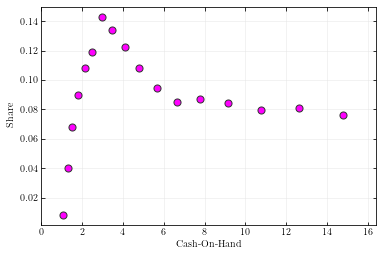

In [17]:
# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.scatter(bin_centers, h_share_means, s=50, c='magenta', marker='o', edgecolors = '0.2', zorder=2) 

# Plot setting
ax.set_xlabel('Cash-On-Hand')
ax.set_ylabel('Share')

ax.set_xlim(0,16.4)
# ax.set_ylim(0.07,0.3)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend()

plt.savefig('../../tex/figs/h_share_bins.pdf')

# Find SS for lower interest rate

Save some statistics needed

In [22]:
h_init = model.sim.n
w_init = (model.sim.m + model.par.ph*model.sim.n) / model.sim.y

Define model2 with lower interest rates

In [23]:
# Define the model
R_low = 1.02
model2 = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'R':R_low, 'ph':p, 'do_print':False})

# Solve and simulate
model2.precompile_numba()
model2.solve()
model2.simulate()

In [13]:
print(Hs)

0.31576333475798035


In [14]:
# Grid over house prices
Nr = 15
p_vec = np.linspace(.3,3.0,Nr)
p_min = p_vec[0]
p_max = p_vec[Nr-1]

# Supply set to same value as the previous model

# Initialize demand function
Hd = np.zeros(shape=len(p_vec))

# Loop
t0 = time.time()
for i_p,p in enumerate(p_vec):
    
    # Solve and simulate model
    model2.par.ph = p
    model2.solve()
    model2.simulate()
    
    # Aggregate demand
    Hd[i_p] = np.mean(model2.sim.d[-1,:])
    
    # Bound on p
    diff = Hs - Hd[i_p]
    if diff < 0: p_min = np.fmax(p_min, p_vec[i_p])
    if diff > 0: p_max = np.fmin(p_max, p_vec[i_p])
    
    # print(i_p)
    
t1 = time.time()

In [21]:
def obj(p,model2):
    
    model2.par.ph = p
    model2.solve()
    model2.simulate()
    return np.mean(model2.sim.d[-1,:]) - Hs

t0 = time.time()

opt = optimize.root_scalar(obj,bracket=[p_min,p_max],method='bisect',args=(model2,),maxiter=100)
model2.par.ph = opt.root
assert opt.converged

t1 = time.time()
print(t1-t0)

582.8202826976776


In [22]:
opt.root

0.8585266883781775

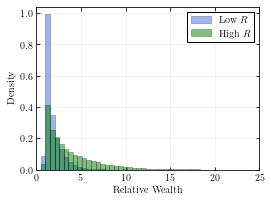

In [47]:
# Define wealth
w = (model2.sim.m + model2.par.ph*model2.sim.n) / model2.sim.y

# w = model.sim.a + model.sim.d

# Initialize the figure
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.hist(w[-1,:], bins = np.linspace(0,25,50), density = True, edgecolor = 'k', linewidth=.5, zorder=2, color ='royalblue', alpha = .5, label = r'Low $R$')
ax.hist(w_init[-1,:], bins = np.linspace(0,25,50), density = True, edgecolor = 'k', linewidth=.5, zorder=2, color ='green', alpha = .5, label = r'High $R$')

# Plot setting
ax.set_xlabel('Relative Wealth')
ax.set_ylabel('Density')
ax.set_xlim(0,25)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False, prop={'size': 10})

plt.savefig('../../tex/figs/w_distr_compare.pdf')

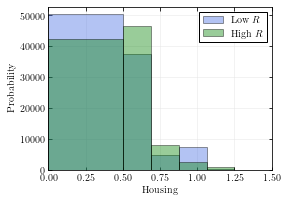

In [26]:
# Initialize the figure
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.hist(model2.sim.d[-1,:], model2.par.grid_n, density = False, facecolor='royalblue', edgecolor = 'k', zorder=2, alpha = .4, label = r'Low $R$')
ax.hist(h_init[-1,:], model2.par.grid_n, density = False, facecolor='green', edgecolor = 'k', zorder=2, alpha = .4, label = r'High $R$')

# Plot setting
ax.set_xlabel('Housing')
ax.set_ylabel('Probability')

ax.set_xlim(0,1.5)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False,  prop={'size': 10})

plt.savefig('../../tex/figs/h_distr_compare.pdf')

In [51]:
# try binned scatterplot
h_demand_means, bin_edges, binnumber = stats.binned_statistic(model2.sim.m[-1,:],model2.sim.d[-1,:], bins = np.logspace(0,2,30), statistic = 'mean')

# Compute bins
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

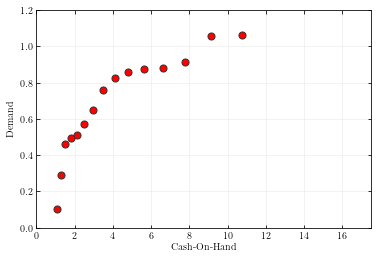

In [56]:
# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.scatter(bin_centers, h_demand_means, s=50, c='red', marker='o', edgecolors = '0.2', zorder=2) 

# Plot setting
ax.set_xlabel('Cash-On-Hand')
ax.set_ylabel('Demand')

ax.set_xlim(0,17.5)
ax.set_ylim(0,1.2)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend()

plt.savefig('../../tex/figs/h_demand_bins_low.pdf')